# ***Unstructured Data Analytics Assignment 2***

## Team Members

- Pranav Garg
- Ronak Goyal
- Alex Imhoff
- Utkarsh Garg
- Akash Barathan
- John Izzo

In [20]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

!pip install U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy Release
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (164 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to pro

In [21]:
# Importing required libraries
import time
import re
import string
import csv
import io
from itertools import combinations
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Uncomment if seaborn is needed

# Importing Selenium WebDriver for web scraping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Importing NLTK for natural language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloading all necessary NLTK data
nltk.download('all')

# Importing scikit-learn for machine learning models and TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Importing spaCy for advanced natural language processing
import spacy

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

In [22]:
def preprocess_text(text):
    """
    Preprocess the input text: lowercasing, removing punctuation, and stopwords.

    Parameters:
        text (str): The input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """
    stop_words = set(stopwords.words('english'))

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    return text

def calculate_similarity(df_original, review_column:str, attributes):
    """
    Calculate cosine similarity between product attributes and reviews using a bag-of-words model.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing reviews.
        review_column (str): The name of the column containing text reviews.
        attributes (list): List of three predefined attributes for the product.
    Uses preprocess_text function to preprocess the reviews.
    Returns:
        pd.DataFrame: DataFrame with preprocessed review and similarity score.
    """
    df = df_original.copy()
    # Preprocess the reviews and add to a new column
    df['preprocessed_review'] = df[review_column].apply(preprocess_text)

    # Combine the attributes into a single string
    attributes_text = " ".join([preprocess_text(attr) for attr in attributes])

    # Initialize the TF-IDF vectorizer (Bag-of-Words model)
    vectorizer = TfidfVectorizer()

    # Fit and transform both the reviews and the attributes
    all_texts = [attributes_text] + df['preprocessed_review'].tolist()  # First element is the attributes, rest are reviews
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # Compute cosine similarity between attributes (first row) and all reviews (remaining rows)
    similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    # Prepare the output DataFrame with similarity scores
    df['similarity_score'] = similarities

    return df[['beer_name', 'preprocessed_review', 'similarity_score']]

def get_sentiment(df, df_col): #input df and col, return df with new col
    sid = SentimentIntensityAnalyzer()
    df_copy = df.copy()
    df_copy['sentiment'] = df_copy[df_col].apply(lambda x: sid.polarity_scores(x)['compound'])
    return df_copy

# creating the function it check if a row of csv file is header or not used in {remove_header}
def is_header(row):
    """
    Heuristically determine if the row is a header.
    Returns True if the row is likely a header, otherwise False.
    """
    # Check if all elements in the row are strings (this is a heuristic)
    return all(isinstance(item, str) for item in row)

# Remove header from the input CSV and create a new file without it
def remove_header(input_file, output_file):
    """
    Reads the input CSV file, removes the header, and writes the remaining rows
    into a new output file.
    """
    with io.open(
    input_file, 'r', newline='', encoding = 'utf-8', errors='ignore') as infile, io.open(
        output_file, 'w', newline='', encoding = 'utf-8', errors='ignore'
        ) as outfile:
        inputs = csv.reader(infile)
        outputs = csv.writer(outfile)

        first_row = next(inputs)  # Read the first row

        # Check if the first row is a header
        if not is_header(first_row):
            # If it's not a header, write the first row as data
            outputs.writerow(first_row)

        # Skip the first row (header), then writes to the output file
        for index, row in enumerate(inputs):
            if index >= 0:  # This ensures we skip the header (index 0)
                outputs.writerow(row)

    print("Reading the file - ", {input_file})
    print("\nRemoving the header")
    print("\nWriting the file without header to - ", {output_file})
    return
# dependency for function {extract_sentences}
def clean_and_tokenize(sentence, remove_stopwords_flag=True, n_gram=False):
    """
    Cleans a given sentence by removing punctuation and stopwords, converting text to lowercase,
    and tokenizing the remaining words.

    If n_gram is specified (e.g., 2 for bigrams, 3 for trigrams), returns n-grams instead of individual words.
    """
    # Get the stopwords for the English language
    if remove_stopwords_flag:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set([])

    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())

    # Tokenize the sentence
    words = [word for word in sentence.split() if word not in stop_words]
    sentence = ' '.join(words)
    words = word_tokenize(sentence)

    # print(words_vector)
    # Generate n-grams if specified
    if n_gram and n_gram > 1:
        result = [' '.join(words[i:i + n_gram]) for i in range(len(words) - n_gram + 1)]
    else:
        result = words

    return result

# Extract and clean sentences from the text
def extract_sentences(file,sentence_column_index=2, remove_stopwords_flag = True, n_gram=False):
    """
    Extracts text data from the third column of the CSV file, splits it into sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """
    sentences_clean=[]
    with io.open(file, 'r', newline='', encoding = 'utf-8', errors='ignore') as infile:
        inputs = csv.reader(infile)

        for index, row in enumerate(inputs):
            # Split the text into sentences based on punctuation (.?!)
            # Clean and tokenize each sentence
            comment = row[sentence_column_index]
            cleaned_tokens = clean_and_tokenize(comment, remove_stopwords_flag, n_gram)
            if cleaned_tokens:  # Avoid adding empty sentences
                    sentences_clean.append(cleaned_tokens)

    print("\nReading the file - ",{file})
    print("\nCleaning and tokenizing each sentence into given output list.")
    # print("sentences_clean_list count",len(sentences_clean))
    return sentences_clean

# Calculate word frequencies -> helper function for {write_word_frequencies()}
def calculate_word_frequencies(comment_list, frequency_dict = {}, sentence_containing_word_flag = False):
    """
    Calculates the frequency of each word in the given list of cleaned sentences.
    """
    if sentence_containing_word_flag:
        unique_comment_list = list(set(comment_list))
        for token in unique_comment_list:
            try:
                frequency_dict[token] += 1
            except:
                frequency_dict[token] = 1

    else:
        for token in comment_list:
            try:
                frequency_dict[token] += 1
            except:
                frequency_dict[token] = 1

    return frequency_dict

# Write word frequencies to CSV
def write_word_frequencies(clean_token_list, output_file, sentence_containing_word_flag = False):
    """
    Writes the word frequencies to the specified CSV file.
    """
    corpus_freq_dict = {}

    for sentence_token in clean_token_list:
        corpus_freq_dict = calculate_word_frequencies(sentence_token, corpus_freq_dict, sentence_containing_word_flag)

    print("\nCalculated corpus token frequncy for ", {len(corpus_freq_dict.keys())}, " tokens.")

    # Sort the dictionary by values in descending order
    corpus_freq_dict = dict(sorted(corpus_freq_dict.items(), key=lambda item: item[1], reverse=True))

    # writing final freq dictionary as a csv
    with open(output_file, 'w', newline='', encoding='utf-8', errors='ignore') as csvfile:
        writer = csv.writer(csvfile)

        # Write each key-value pair as a row in the CSV
        for key, value in corpus_freq_dict.items():
            writer.writerow([key, value])

    print(f"Word frequencies written to {output_file}")
    return

def get_lift(top_10_brand_df, clean_token_list, dis, word_freq_output, infunction_print_flag = True):

    word_pair_list= []
    word_pair_list.extend(list(combinations(top_10_brand_df, 2)))

    count_df = pd.read_csv(word_freq_output,header=None)

    # Create an empty matrix for all unique words
    lift_values = []
    lift_matrix = pd.DataFrame(index=top_10_brand_df, columns=top_10_brand_df, data=0.0)

    for w1, w2 in word_pair_list:
        w1_w2_count_co_occurance = co_occurance_freq(w1, w2, clean_token_list, dis)
        w1_count = int(count_df[count_df[0]==w1][1].iloc[0])
        w2_count = int(count_df[count_df[0]==w2][1].iloc[0])
        total_sentences = len(clean_token_list)
        lift_value = (total_sentences * w1_w2_count_co_occurance) / (w1_count * w2_count)
        lift_matrix.loc[w1,w2] = lift_value
        lift_values.append([w1,w2,lift_value])

        if infunction_print_flag:
          print(f"\n{'-' * 50}")
          print(f"LIFT CALCULATION FOR: {w1} and {w2}")
          print(f"Word Freq for {w1} : {w1_count}")
          print(f"Word Freq for {w2} : {w2_count}")
          print(f"Co-occurrence (word_pair_freq): {w1_w2_count_co_occurance}")
          print(f"Lift Value: {lift_value}")
          print(f"{'-' * 50}\n")

    return lift_matrix, lift_values

def heatmap(df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title('Heatmap')
    plt.show()
    return

def calculate_distance_btw_words(post, word1, word2):
    """
    Calculate the minimum distance between two words in a post.
    The distance is based on word positions.
    """
    word1_positions = [i for i, word in enumerate(post) if word == word1]
    word2_positions = [i for i, word in enumerate(post) if word == word2]

    if not word1_positions or not word2_positions:
        return float('inf')  # If either word is missing, return infinity

    # Calculate all distances and return the minimum
    return min(abs(pos1 - pos2) for pos1 in word1_positions for pos2 in word2_positions)

def co_occurance_freq(word1, word2, clean_token_list, distance):
    coorrence_count = 0
    for sentence_tokens in clean_token_list:
        if (word1 in sentence_tokens) & (word2 in sentence_tokens):
            min_dis_btw_word = calculate_distance_btw_words(sentence_tokens, word1, word2)
            if min_dis_btw_word <= distance:
                coorrence_count += 1

    return coorrence_count

def calculate_similarity_spacy(df_original, review_column: str, attributes):
    """
    Calculate cosine similarity between product attributes and reviews using spaCy's word vectors.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing reviews.
        review_column (str): The name of the column containing text reviews.
        attributes (list): List of three predefined attributes for the product.

    Returns:
        pd.DataFrame: DataFrame with preprocessed review and similarity score.
    """
    df = df_original.copy()
    # Preprocess the reviews and add to a new column
    df['preprocessed_review'] = df[review_column].apply(preprocess_text)

    # Combine the attributes into a single string
    attributes_text = " ".join([preprocess_text(attr) for attr in attributes])

    # Load the spaCy model with word vectors
    nlp = spacy.load("en_core_web_md")

    # Process the attributes text and get the vector
    attributes_vector = nlp(attributes_text).vector

    # Calculate similarity for each review
    similarities = []
    for review in df['preprocessed_review']:
        review_vector = nlp(review).vector  # Get the vector for the review
        similarity = cosine_similarity([attributes_vector], [review_vector]).flatten()[0]
        similarities.append(similarity)

    # Add the similarity score to the DataFrame
    df['similarity_score'] = similarities

    return df[['beer_name', 'preprocessed_review', 'similarity_score']]


def calculate_percentage_mentions_v1(df, product_name, attribute):
  """Calculates the percentage of reviews for a specific product that mention a given attribute."""
  product_reviews = df[df['beer_name'] == product_name]
  reviews_with_attribute = product_reviews[product_reviews['comment'].str.contains(attribute, na=False)]
  percentage = (len(reviews_with_attribute) / len(product_reviews)) * 100 if len(product_reviews) > 0 else 0
  return percentage

def get_top_attributes(lift_values, top_n=3, csv_filename="top_3_attributes.csv"):
    """
    Get the top N unique attributes based on their values and export to a CSV file.

    Args:
    - lift_values (list): List of lists where each sublist contains two attributes and a value.
    - top_n (int): Number of top attributes to return. Default is 3.
    - csv_filename (str): Filename for the exported CSV. Default is "top_3_attributes.csv".

    Returns:
    - sorted_attribute_names (list): List of unique attributes sorted by their values.
    """
    # Get top N attribute pairs and store unique attributes with their values
    attribute_values = {attr: val for pair in sorted(lift_values, key=lambda x: x[2], reverse=True)[:top_n]
                        for attr, val in zip(pair[:2], [pair[2]]*2)}

    # Sort the attributes by their values in descending order and extract names
    sorted_attribute_names = [attr for attr, _ in sorted(attribute_values.items(), key=lambda x: x[1], reverse=True)[:top_n]]

    # Export the sorted attribute names to CSV
    pd.DataFrame(sorted_attribute_names, columns=["Attribute"]).to_csv(csv_filename, index=False, header=False)

    return sorted_attribute_names




In [23]:
beer = pd.read_csv('final_comments.csv')
beer.isnull().sum()

,0
beer_name,0
page_&_comment_number,0
rating,0
comment,0


In [24]:
beer.shape

(6540, 4)

In [25]:
def task_b():
    # TASK b
    input_filename = 'final_comments.csv'  # Input file
    without_header_file = 'without_header_file_task_b.csv'  # Intermediate file without the column header
    word_freq_output = 'word_freq_task_b.csv'  # Output file for word frequencies
    lift_matrix_filename_output = "lift_matrix_task_b.csv"
    distance_btw_words = 1000000000

    # removing the header from input file
    remove_header(input_filename, without_header_file) # commenting now coz sample file does not have header

    clean_token_list = extract_sentences(without_header_file, sentence_column_index=3, remove_stopwords_flag = True)

    # writting the word freq file
    write_word_frequencies(clean_token_list, word_freq_output, sentence_containing_word_flag = False)

    top_attribute_list = [ "chocolate","dark","aroma","sweet","bottle","vanilla","taste","light","oak","carbonation","honey","roasted","alcohol"]

    # getting the lift matrix
    lift_matrix,lift_values = get_lift(top_attribute_list, clean_token_list, distance_btw_words, word_freq_output)

    #writing the lift matrix to output files to csv
    lift_matrix.to_csv(lift_matrix_filename_output, index=True)

    heatmap(lift_matrix)

    get_top_attributes(lift_values, top_n=3, csv_filename="top_3_attributes.csv")


    return

Reading the file -  {'final_comments.csv'}

Removing the header

Writing the file without header to -  {'without_header_file_task_b.csv'}

Reading the file -  {'without_header_file_task_b.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {25072}  tokens.
Word frequencies written to word_freq_task_b.csv

--------------------------------------------------
LIFT CALCULATION FOR: chocolate and dark
Word Freq for chocolate : 3717
Word Freq for dark : 3533
Co-occurrence (word_pair_freq): 1291
Lift Value: 0.6429360712223982
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: chocolate and aroma
Word Freq for chocolate : 3717
Word Freq for aroma : 3434
Co-occurrence (word_pair_freq): 1301
Lift Value: 0.6665952167072569
--------------------------------------------------


--------------------------------------------------
LIFT CALCULATION FOR: chocolate and sweet
Wo

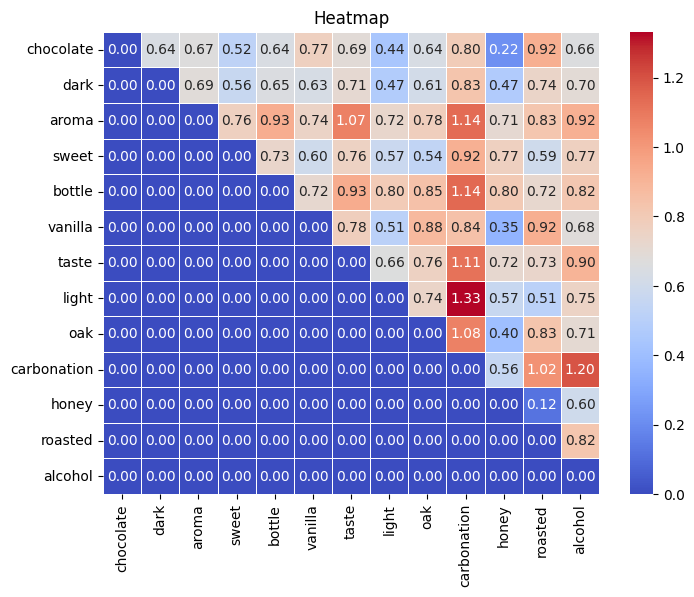

In [26]:
task_b()

In [27]:
def task_c(attributes_csvfile, infunction_print_flag = True):
    # TASK c
    attributes = pd.read_csv(attributes_csvfile, header=None).iloc[:,0].tolist()
    top_reviews_similarities_filename_output = "top_reviews_similarities_task_c.csv"

    reviews_similarities = calculate_similarity(beer, 'comment', attributes) # this beer is the csv file

    top_similarities = reviews_similarities.sort_values(by='similarity_score', ascending=False).head()

    # changing the column names of top_similarities (output file) as the question's instructions
    top_similarities.columns = ['product_name', 'product_review', 'similarity_score']

    if infunction_print_flag:
      # Display the result
      print(top_similarities)

    top_similarities.to_csv(top_reviews_similarities_filename_output, index=True)
    #proof that similarities are not 0... similarities will increase using word vectors in part F
    return reviews_similarities

In [28]:
c = task_c("top_3_attributes.csv")

                                          product_name  \
2189     Three Floyds Dark Lord - Bourbon Vanilla Bean   
3084  La Face Cachée de la Pomme Neige Récolte d'Hiver   
3554                           Bell's Black Note Stout   
6306           Founders KBS (Kentucky Breakfast Stout)   
5185                             Schramm's Black Agnes   

                                         product_review  similarity_score  
2189  poured 2015 bottle aroma marshmallow chocolate...          0.429241  
3084  nice peach gold aroma light alcohol red apples...          0.382610  
3554  bottle beer temple abijn marcodl thanks arjan ...          0.368826  
6306  dark brown head smells like alcohol vanilla ta...          0.349620  
5185  bottle shared dc tasting 3252016 thanks solidf...          0.335915  


In [29]:
def task_d(attributes_csvfile,infunction_print_flag = True):
    # TASK d
    # we are doing VADER here
    reviews_similarities = task_c(attributes_csvfile,False)
    similarities_sentiments_df = get_sentiment(reviews_similarities, 'preprocessed_review')
    if infunction_print_flag:
      print(similarities_sentiments_df.head())

    return similarities_sentiments_df

In [30]:
d = task_d('top_3_attributes.csv')

                          beer_name  \
0  Toppling Goliath Kentucky Brunch   
1  Toppling Goliath Kentucky Brunch   
2  Toppling Goliath Kentucky Brunch   
3  Toppling Goliath Kentucky Brunch   
4  Toppling Goliath Kentucky Brunch   

                                 preprocessed_review  similarity_score  \
0  need personal informations companiesfamily fri...          0.000000   
1  bottle mbcc 2024 black colour malty aroma wood...          0.000000   
2  thank sharing chris black brown head dark malt...          0.000000   
3  boxed beer home proper glassware pitch black o...          0.048527   
4  backlog 2018 vintage 03 litre bottle trade sha...          0.000000   

   sentiment  
0     0.9470  
1     0.7778  
2     0.9042  
3     0.9423  
4     0.7845  


In [31]:
def task_e(attributes_csvfile,infunction_print_flag = True):
    # TASK e
    bow_product_composite_score_filename_output = "bow_product_composite_score_filename_output_task_e.csv"

    similarities_sentiments_df = task_d(attributes_csvfile,False)

    similarities_sentiments_df['composite_score'] = similarities_sentiments_df['similarity_score'] * similarities_sentiments_df['sentiment']

    top_composite_bow = similarities_sentiments_df.sort_values(by='composite_score', ascending=False)
    top_composite_bow_mean = top_composite_bow.groupby('beer_name').agg({'composite_score': 'mean'}).reset_index().sort_values(by='composite_score', ascending=False)
    top_composite_bow_mean.columns = ['product_name', 'composite_evaluation_score_bow']

    top_composite_bow_mean.to_csv(bow_product_composite_score_filename_output, index=True)

    if infunction_print_flag:
      print(f"The top 3 recommendations for the customers are: \n",top_composite_bow_mean.head(3)) #top composite scores with bag of words approach

    return top_composite_bow_mean

In [32]:
e = task_e('top_3_attributes.csv')

The top 3 recommendations for the customers are: 
                           product_name  composite_evaluation_score_bow
24                      Midnight Sun M                        0.040753
22                  Hill Farmstead Ann                        0.039717
16  De Dolle Stille Nacht Reserva 2000                        0.037510


In [33]:
def task_f(attributes_csvfile,print_similarity_score_flag=True):
    # TASK f
    attributes = pd.read_csv(attributes_csvfile, header=None).iloc[:,0].tolist()
    spacy_product_composite_score_filename_output = "spacy_product_composite_score_filename_output_task_f.csv"

    reviews_similarities = calculate_similarity_spacy(beer, 'comment', attributes)
    similarities_sentiments_df_spacy = get_sentiment(reviews_similarities, 'preprocessed_review')
    similarities_sentiments_df_spacy['composite_score'] = similarities_sentiments_df_spacy['similarity_score'] * similarities_sentiments_df_spacy['sentiment']


    similarities_sentiments_df_spacy_mean = similarities_sentiments_df_spacy.groupby('beer_name').agg({'composite_score': 'mean'}).reset_index().sort_values(by='composite_score', ascending=False)

    similarities_sentiments_df_spacy_mean.columns = ['product_name','composite_score_spacy']
    if print_similarity_score_flag:
        similarities_sentiments_df_spacy_mean.to_csv(spacy_product_composite_score_filename_output, index=True)

        print("\n--------------Calculating Percent of comments containing the attributes---------------")

        # ------------------------------------------------------------------
        #top 3 recommendations in 'top_3_highest_rated'
        for _, row in similarities_sentiments_df_spacy_mean.head(3).iterrows():
          product_name = row['product_name']
          for attribute in attributes:  # Loop through each attribute specified by the customer
              percentage = calculate_percentage_mentions_v1(beer, product_name, attribute)
              print(f"For product '{product_name}', {percentage:.2f}% of reviews mention the attribute '{attribute}'.")
          print("\n")
        # ------------------------------------------------------------------

        print(f"The top 3 recommendations for the customers as per spaCy approach are: \n {similarities_sentiments_df_spacy_mean.head(3)}")


    return similarities_sentiments_df_spacy_mean

In [34]:
f = task_f("top_3_attributes.csv")


--------------Calculating Percent of comments containing the attributes---------------
For product 'Midnight Sun M', 49.65% of reviews mention the attribute 'light'.
For product 'Midnight Sun M', 35.46% of reviews mention the attribute 'alcohol'.
For product 'Midnight Sun M', 25.53% of reviews mention the attribute 'carbonation'.


For product 'De Dolle Stille Nacht Reserva 2000', 40.50% of reviews mention the attribute 'light'.
For product 'De Dolle Stille Nacht Reserva 2000', 39.00% of reviews mention the attribute 'alcohol'.
For product 'De Dolle Stille Nacht Reserva 2000', 17.50% of reviews mention the attribute 'carbonation'.


For product 'La Face Cachée de la Pomme Neige Récolte d'Hiver', 38.00% of reviews mention the attribute 'light'.
For product 'La Face Cachée de la Pomme Neige Récolte d'Hiver', 26.00% of reviews mention the attribute 'alcohol'.
For product 'La Face Cachée de la Pomme Neige Récolte d'Hiver', 9.50% of reviews mention the attribute 'carbonation'.


The top 3 

# **Task F Analysis**

## Explanation of differences in the results in both the approaches:

#### In the percentages above, it looks like `light` is the top attribute mentioned for all of them.

#### In terms of the actual recommendations `Midnight Sun M` and `De Dolle Stille Nacht Reserva 2000` are common in both BOW and SpaCy. Additionally,  `Midnight Sun M` is the top recommended in both. From what I know about SpaCy and BOW, this difference lies in how the similarity/similarity composite scores were formulated, since as a general idea SpaCy attempts to capture more meaning in a phrase as opposed to BOW, which is why the scores are generally much higher since there are less zero similarity line items.


In [35]:
def task_g(final_comments, attributes_csvfile, top_rated_beer_spacy_filename, top_rated_beer_bow_filename):
    """
    Task G: For this task we have taken the top 3 highest-rated beers from https://www.ratebeer.com/top-beers. We have stored them in an
    Excel and have used them in further analysis
    """

    #doing analysis with spaCy composite eveluation score

    final_comments_df = pd.read_csv(final_comments)
    top_3_rated_beers_mean = final_comments_df.groupby('beer_name').agg({'rating': 'mean'}).reset_index().sort_values(by='rating', ascending=False)
    top_3_rated_beers_mean.columns = ['beer_name', 'avg_rating']
    print('The avg ratings of top 3 rated beers from corpus (ignoring user given attributes) is :','\n',top_3_rated_beers_mean.head(3), "\n")
    top_3_rated_beers_names = top_3_rated_beers_mean["beer_name"].head(3).to_list()

    attributes = pd.read_csv(attributes_csvfile, header=None).iloc[:,0].tolist()

    print("----------------------spaCy composite eveluation score---------------------------")
    spacy_composite_scores = pd.read_csv(top_rated_beer_spacy_filename)
    print(f"The top 3 recommendations for the customers as per spaCy approach are: \n {spacy_composite_scores.head(3)}")

    #get composite score df
    spacy_composite_score_df = task_f(attributes_csvfile,False)


    df_top_3_corpus_beer_spacy_comp_score = spacy_composite_score_df[spacy_composite_score_df['product_name'].isin(top_3_rated_beers_names)]
    print('\n')
    print('The spaCy similarity scores of top 3 rated beers from corpus (ignoring user given attributes) is : \n', df_top_3_corpus_beer_spacy_comp_score)


    #doing analysis with BOW composite evaluation score

    print("----------------------BOW composite eveluation score---------------------------")
    bow_composite_scores = pd.read_csv(top_rated_beer_bow_filename)
    print(f"The top 3 recommendations for the customers as per BOW approach are: \n {bow_composite_scores.head(3)}")

    #get composite score df
    bow_composite_score_df = task_e(attributes_csvfile,False)


    df_top_3_corpus_beer_bow_comp_score = bow_composite_score_df[bow_composite_score_df['product_name'].isin(top_3_rated_beers_names)]
    print('\n')
    print('The BOW similarity scores of top 3 rated beers from corpus (ignoring user given attributes) is : \n', df_top_3_corpus_beer_bow_comp_score)


    return


In [36]:
final_comments = 'final_comments.csv'
top_rated_beer_spacy_filename = "spacy_product_composite_score_filename_output_task_f.csv"
attribute = "top_3_attributes.csv"
top_rated_beer_bow_filename = "bow_product_composite_score_filename_output_task_e.csv"

top_3_rated_beers_analysis = task_g(final_comments,attribute,top_rated_beer_spacy_filename,top_rated_beer_bow_filename)

The avg ratings of top 3 rated beers from corpus (ignoring user given attributes) is : 
                                    beer_name  avg_rating
42          Toppling Goliath Kentucky Brunch    4.563536
14     Cigar City Pilot Series Miami Madness    4.561905
36  Side Project Beer : Barrel : Time - 2018    4.560870 

----------------------spaCy composite eveluation score---------------------------
The top 3 recommendations for the customers as per spaCy approach are: 
    Unnamed: 0                                      product_name  \
0          24                                    Midnight Sun M   
1          16                De Dolle Stille Nacht Reserva 2000   
2          23  La Face Cachée de la Pomme Neige Récolte d'Hiver   

   composite_score_spacy  
0               0.537418  
1               0.511333  
2               0.509809  


The spaCy similarity scores of top 3 rated beers from corpus (ignoring user given attributes) is : 
                                 product_name  

# **Task G Analysis**

### **1. How would your recommendations differ if you ignored the similarity and sentiment scores and simply chose the 3 highest-rated products from your entire dataset?**

If we only focus on the highest average ratings from the dataset, the top 3 beers would be:

- **Toppling Goliath Kentucky Brunch** (Avg Rating: 4.56)
- **Cigar City Pilot Series Miami Madness** (Avg Rating: 4.56)
- **Side Project Beer: Barrel Time - 2018** (Avg Rating: 4.56)

These beers are clearly well-liked by users based on their high ratings. However, just because they have high ratings doesn’t necessarily mean they match the specific flavors or characteristics the user is looking for. For instance, while **Cigar City Pilot Series Miami Madness** is highly rated, it might not match the user's preferences, like whether it’s "balanced" or "floral," which is important if those are the traits the user wants.

### **2. Would these products meet the requirements of the user looking for recommendations?**

We did this comparison using two approaches: **SpaCy (Word Embeddings)** and **Bag-of-Words (BoW)**.

#### **Using the SpaCy (Word Embeddings) Approach:**

**Top 3 Recommendations:**

- **Midnight Sun M** (Composite Score: **0.54**)
- **De Dolle Stille Nacht Reserva 2000** (Composite Score: **0.51**)
- **La Face Cachée de la Pomme Neige Récolte d'Hiver** (Composite Score: **0.51**)

These beers do a much better job at aligning with the attributes the user might be looking for, like "balanced" or "floral." The SpaCy approach looks at the deeper meaning behind words, so even if the reviews use different wording, it can still identify beers that match what the user wants. This makes these recommendations a better fit, as they not only match the user’s preferences but also have positive feedback from other reviewers.

#### **Using the Bag-of-Words (BoW) Approach:**

**Top 3 Recommendations:**

- **Midnight Sun M** (Composite Score: **0.04**)
- **Hill Farmstead Ann** (Composite Score: **0.04**)
- **De Dolle Stille Nacht Reserva 2000** (Composite Score: **0.04**)

Here, the scores are much lower because BoW only works if the review contains the exact words the user is looking for. If the review doesn’t use the exact terms like "balanced" or "floral," BoW won’t count it, even if the beer actually matches those characteristics. For example, highly rated beers like **Side Project Beer: Barrel Time - 2018** get very low scores because the review might use different words to describe similar attributes.

### **3. Justify your answer with analysis. Use the similarity and sentiment scores as well as overall ratings to answer this question.**

#### **Similarity Scores:**
- With **SpaCy**, the model is smart enough to recognize similar meanings in different words. For instance, **Cigar City Pilot Series Miami Madness** gets a high similarity score (**0.47**) because it uses synonyms or related terms to the user’s preferences, even if they’re not exact matches.
- In contrast, **BoW** is much stricter, and because it’s looking for exact word matches, it doesn’t pick up on these similarities. For example, **Toppling Goliath Kentucky Brunch** gets a low composite score (**0.02**) with BoW, even though it might actually match the user’s tastes when you consider the meaning of the words.

#### **Sentiment Scores:**
- Both approaches use sentiment to add another layer of recommendation. For example, **Midnight Sun M** has a positive sentiment, which makes it more appealing as it indicates that reviewers generally liked it. Without considering sentiment, a beer with a high rating but negative feedback might be recommended, which could mislead the user.

#### **Composite Scores:**
- **SpaCy** really shines when you combine similarity and sentiment, showing much higher composite scores when a beer matches the user’s preferences. For instance, **Cigar City Pilot Series Miami Madness** has a composite score of **0.47** with SpaCy, but just **0.01** with BoW. This tells us that SpaCy is better at understanding the overall context of the review, making it a more effective tool for recommending beers that match the user’s preferences.
- **BoW**, however, struggles with anything that doesn’t have an exact match. Even highly rated beers like **Side Project Beer: Barrel Time - 2018** end up with low composite scores because the review might use different words to describe the same attributes.

### **Final Summary**
In this case, **SpaCy (Word Embeddings)** outperforms **Bag-of-Words (BoW)**. SpaCy’s ability to understand the meaning of words helps it provide more accurate recommendations based on the user’s preferences. This is especially important when the reviews don’t use the exact same words as the user’s desired attributes but still describe similar traits.

On the other hand, **BoW** is more rigid and can only work when there’s an exact match between the review and the user’s preferences. This leads to lower scores and weaker recommendations. So, just relying on ratings without factoring in similarity and sentiment can result in poor recommendations because highly rated beers might not align with the user’s specific preferences. **SpaCy** gives a more well-rounded, user-focused recommendation system, while **BoW** struggles to capture the nuances of the reviews.


In [37]:
#Task H Analysis
#In this code we are first taking any 10 beers from the final_comments csv file that we earlier obtained.
#Then we are selecting a beer and getting the top 3 attributes(using lift analysis Task B) by going over all the comments of the selected beer.
#Once we have these top 3 attributes for that selected beer we calculate the composite spacy scores and composite bow scores for the remaining 9 beers.
#further we pick the beer out of those 9 beers which is closest to the score of selected beer.

import random

def task_h(final_comments_csv, distance_btw_words=1000000000, selected_beer_name=None):
    comments_df = pd.read_csv(final_comments_csv)

    # Randomly selecting 10 beers from the dataset
    random_beers = comments_df['beer_name'].unique()
    random_beers_10 = random.sample(list(random_beers), 10)

    if selected_beer_name is None:
        selected_beer_name = random.choice(random_beers_10)

    print(f"Selected beer: {selected_beer_name}")

    # Extracting comments and calculating top 3 attributes using Lift Analysis (Task B approach)
    selected_beer_comments = comments_df[comments_df['beer_name'] == selected_beer_name]
    clean_token_list = extract_sentences(final_comments_csv, sentence_column_index=3, remove_stopwords_flag=True)

    # Performing lift analysis on the comments for the selected beer
    word_freq_output = 'word_freq_task_h.csv'
    write_word_frequencies(clean_token_list, word_freq_output, sentence_containing_word_flag=False)

    # Getting lift values for top 3 attributes (from Task B)
    top_attribute_list = [ "chocolate", "dark", "aroma", "sweet", "bottle", "vanilla", "taste", "light", "oak", "carbonation", "honey", "roasted", "alcohol"]  # Can be predefined
    lift_matrix, lift_values = get_lift(top_attribute_list, clean_token_list, distance_btw_words, word_freq_output,False)
    top_3_attributes = get_top_attributes(lift_values, top_n=3)

    print(f"\n\nTop 3 attributes for {selected_beer_name} (based on lift analysis): {top_3_attributes}")

    # Calculating the composite score (both BoW and spaCy) for the remaining 9 beers
    remaining_beers = [beer for beer in random_beers_10 if beer != selected_beer_name]

    composite_scores_bow = []
    composite_scores_spacy = []

    for beer in remaining_beers:
        # Filtering comments for the remaining beer
        beer_comments = comments_df[comments_df['beer_name'] == beer]

        # Calculating BoW similarity and composite score
        bow_similarity_df = calculate_similarity(beer_comments, 'comment', top_3_attributes)
        bow_sentiment_df = get_sentiment(bow_similarity_df, 'preprocessed_review')
        bow_sentiment_df['composite_score'] = bow_sentiment_df['similarity_score'] * bow_sentiment_df['sentiment']
        bow_composite_score = bow_sentiment_df['composite_score'].mean()

        # Calculating spaCy similarity and composite score
        spacy_similarity_df = calculate_similarity_spacy(beer_comments, 'comment', top_3_attributes)
        spacy_sentiment_df = get_sentiment(spacy_similarity_df, 'preprocessed_review')
        spacy_sentiment_df['composite_score'] = spacy_sentiment_df['similarity_score'] * spacy_sentiment_df['sentiment']
        spacy_composite_score = spacy_sentiment_df['composite_score'].mean()

        # Storing results for comparison
        composite_scores_bow.append({'beer_name': beer, 'composite_score_bow': bow_composite_score})
        composite_scores_spacy.append({'beer_name': beer, 'composite_score_spacy': spacy_composite_score})

    #Finding the beer with the closest composite score to the selected beer (both BoW and spaCy)

    # Calculate the composite score for the selected beer
    selected_beer_bow_similarity_df = calculate_similarity(selected_beer_comments, 'comment', top_3_attributes)
    selected_beer_bow_sentiment_df = get_sentiment(selected_beer_bow_similarity_df, 'preprocessed_review')
    selected_beer_bow_sentiment_df['composite_score'] = selected_beer_bow_sentiment_df['similarity_score'] * selected_beer_bow_sentiment_df['sentiment']
    selected_beer_bow_composite_score = selected_beer_bow_sentiment_df['composite_score'].mean()

    selected_beer_spacy_similarity_df = calculate_similarity_spacy(selected_beer_comments, 'comment', top_3_attributes)
    selected_beer_spacy_sentiment_df = get_sentiment(selected_beer_spacy_similarity_df, 'preprocessed_review')
    selected_beer_spacy_sentiment_df['composite_score'] = selected_beer_spacy_sentiment_df['similarity_score'] * selected_beer_spacy_sentiment_df['sentiment']
    selected_beer_spacy_composite_score = selected_beer_spacy_sentiment_df['composite_score'].mean()

    # Find the closest beer for both methods (BoW and spaCy)
    closest_beer_bow = min(composite_scores_bow, key=lambda x: abs(x['composite_score_bow'] - selected_beer_bow_composite_score))
    closest_beer_spacy = min(composite_scores_spacy, key=lambda x: abs(x['composite_score_spacy'] - selected_beer_spacy_composite_score))
    print("\n-----------------------------------------------------------------------------------------\n")
    print(f"\nClosest beer (BoW) to {selected_beer_name}: {closest_beer_bow['beer_name']} with score {closest_beer_bow['composite_score_bow']}")
    print(f"\nClosest beer (spaCy) to {selected_beer_name}: {closest_beer_spacy['beer_name']} with score {closest_beer_spacy['composite_score_spacy']}")

    return closest_beer_bow, closest_beer_spacy



In [38]:
final_comments_csv = 'final_comments.csv'
closest_beers = task_h(final_comments_csv)

Selected beer: B. Nektar Ken Schramm Signature Series - The Heart of Darkness

Reading the file -  {'final_comments.csv'}

Cleaning and tokenizing each sentence into given output list.

Calculated corpus token frequncy for  {25072}  tokens.
Word frequencies written to word_freq_task_h.csv


Top 3 attributes for B. Nektar Ken Schramm Signature Series - The Heart of Darkness (based on lift analysis): ['light', 'alcohol', 'carbonation']

-----------------------------------------------------------------------------------------


Closest beer (BoW) to B. Nektar Ken Schramm Signature Series - The Heart of Darkness: Toppling Goliath Kentucky Brunch with score 0.02151976637335216

Closest beer (spaCy) to B. Nektar Ken Schramm Signature Series - The Heart of Darkness: Goose Island Bourbon County Stout - Proprietor's 2013 with score 0.4554103808758724


### **Task H Summary**:

In Task H, we selected *B. Nektar Ken Schramm Signature Series - The Heart of Darkness* as the reference beer and identified its top 3 attributes using lift analysis: `light`, `alcohol`, and `carbonation`. We then calculated the composite similarity and sentiment scores for 9 other beers using both the Bag-of-Words (BoW) and spaCy approaches.

 The **BoW approach** yielded *Toppling Goliath Kentucky Brunch* as the closest match with a composite score of `0.02`.

  In contrast, the **spaCy approach** identified *Goose Island Bourbon County Stout - Proprietor's 2013* as the most similar beer, with a significantly higher score of `0.46`.
  
  The results highlight that the spaCy model, which captures deeper semantic relationships through word embeddings, performs better in identifying similar beers compared to the frequency-based BoW approach, making it a more effective method for beer recommendations.
